<a href="https://colab.research.google.com/github/fran-gen/CTG-classification/blob/CTG-sept/CTG_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

- [Intro](#1)
- [2 - Exploratory Data Analysis](#2)
  - [2.1 Missing values and dtypes](#2.1)
  - [2.2 Descriptive statistics](#2.2)
      - [2.2.1 Class distribution](#2.2.1)
      - [2.2.2 Histograms](#2.2.2)
      - [2.2.3 Box plots](#2.2.3)
  - [2.3 Outliers](#2.3)
  - [2.4 Correlation](#2.4)
- [3 - Preprocessing](#3)
- [4 - Gradient Boosting Classifier](#4)
    - [4.1 Grid Search with GBC](#4.4.1)
    - [4.2 Evaluating performance](#4.4.2)

<a name='0'></a>
# **1. Intro**


This dataset consists of 21 features. The feature "NPS" is the dependent variable that represents the health state of the fetus. This variable has three levels:

*   Normal
* Suspect
* Pathological

Therefore, this dataset is best approached as a multi-class classification task.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create dataframe from excel
df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks0/Datasets/CTG.xlsx', sheet_name='Data')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,1,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,22,Unnamed: 44,23
0,b,e,AC,FM,UC,DL,DS,DP,DR,NaN,...,E,AD,DE,LD,FS,SUSP,NaN,CLASS,NaN,NSP
1,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
2,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1


In [ ]:
# Assign the first row's values as the df's column names
df.columns = df.iloc[0]

In [ ]:
# Slice the df from the second row onwards and reassign it to df
df = df[1:]
df.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,NaN,...,E,AD,DE,LD,FS,SUSP,NaN,CLASS,NaN,NSP
1,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
2,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
5,533,1147,4,0,5,0,0,0,0,NaN,...,-1,-1,-1,-1,-1,-1,NaN,2,NaN,1


<a name='2'></a>
# **2. Exploratory Data Analysis**

<a name='2.1'></a>
## **2.1 Missing values and dtypes**

In [ ]:
# Check for null values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 1 to 2129
Data columns (total 46 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   object 
 1   e         2126 non-null   object 
 2   AC        2126 non-null   object 
 3   FM        2127 non-null   object 
 4   UC        2127 non-null   object 
 5   DL        2128 non-null   object 
 6   DS        2128 non-null   object 
 7   DP        2128 non-null   object 
 8   DR        2128 non-null   object 
 9   nan       0 non-null      float64
 10  LB        2126 non-null   object 
 11  AC        2126 non-null   object 
 12  FM        2127 non-null   object 
 13  UC        2127 non-null   object 
 14  DL        2128 non-null   object 
 15  DS        2128 non-null   object 
 16  DP        2128 non-null   object 
 17  ASTV      2127 non-null   object 
 18  MSTV      2127 non-null   object 
 19  ALTV      2127 non-null   object 
 20  MLTV      2127 non-null   obje

In [ ]:
# Let's make a copy of the df, so as to keep track of the original
df2 = df.copy()

Let's get rid of unwanted columns.

In [ ]:
# Drop last three lines
df2 = df2.iloc[:-3]
# Drop columns with nan values only
df2 = df2.dropna(axis=1, how='all')

# Drop first nine columns
df2 = df2.iloc[:, 9:]

# Drop other irrelevant columns
columns_to_drop = ['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS']
df2 = df2.drop(columns=columns_to_drop)

# Turn dtype of all columns into float
df2 = df2.astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 1 to 2126
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   float64
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mode      2126 non-null   float64
 17  Mean      2126 non-null   float64
 18  Median    2126 non-null   float64
 19  Variance  2126 non-null   float64
 20  Tendency  2126 non-null   floa

In [ ]:
df2.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
1,120.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
2,132.0,0.006380,0.0,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
3,133.0,0.003322,0.0,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
4,134.0,0.002561,0.0,0.007682,0.002561,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
5,132.0,0.006515,0.0,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


<a name='2.2'></a>
## **2.2 Descriptive statistics**

<a name='2.2.1'></a>
### **2.2.1 Class distribution**

How are the NSP classes distributed? As can be seen from the bar plot below, we are dealing with an imbalanced dataset. This aspect will require particular attention when evaluating the performance of the algorithm that we will test.

In [ ]:
# Count the frequency of each label in the modified column
df_count = df2["NSP"].replace(
    {1.0: "Normal", 2.0: "Suspect", 3.0: "Pathologic"})
count = df_count.value_counts()

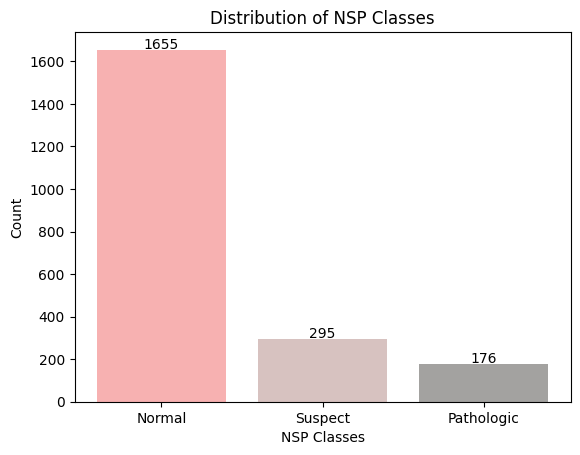

In [ ]:
# Define a color palette
colors = ["#f7b1b1", "#d7c2c0", "#a3a2a0"]

# Create a bar plot with colors
plt.bar(count.index, count.values, color=colors)

# Add labels and title
plt.xlabel("NSP Classes")
plt.ylabel("Count")
plt.title("Distribution of NSP Classes")

# Add actual numbers on top of each bar
for i, value in enumerate(count.values):
    plt.text(i, value + 5, str(value), ha='center')

plt.show()

<a name='2.2.2'></a>
### **2.2.2 Histograms**

Let's now look at the data distributions associated with each feature. We will then visualize the distributions by pairs of NSP classes so as to facilitate a direct comparison.

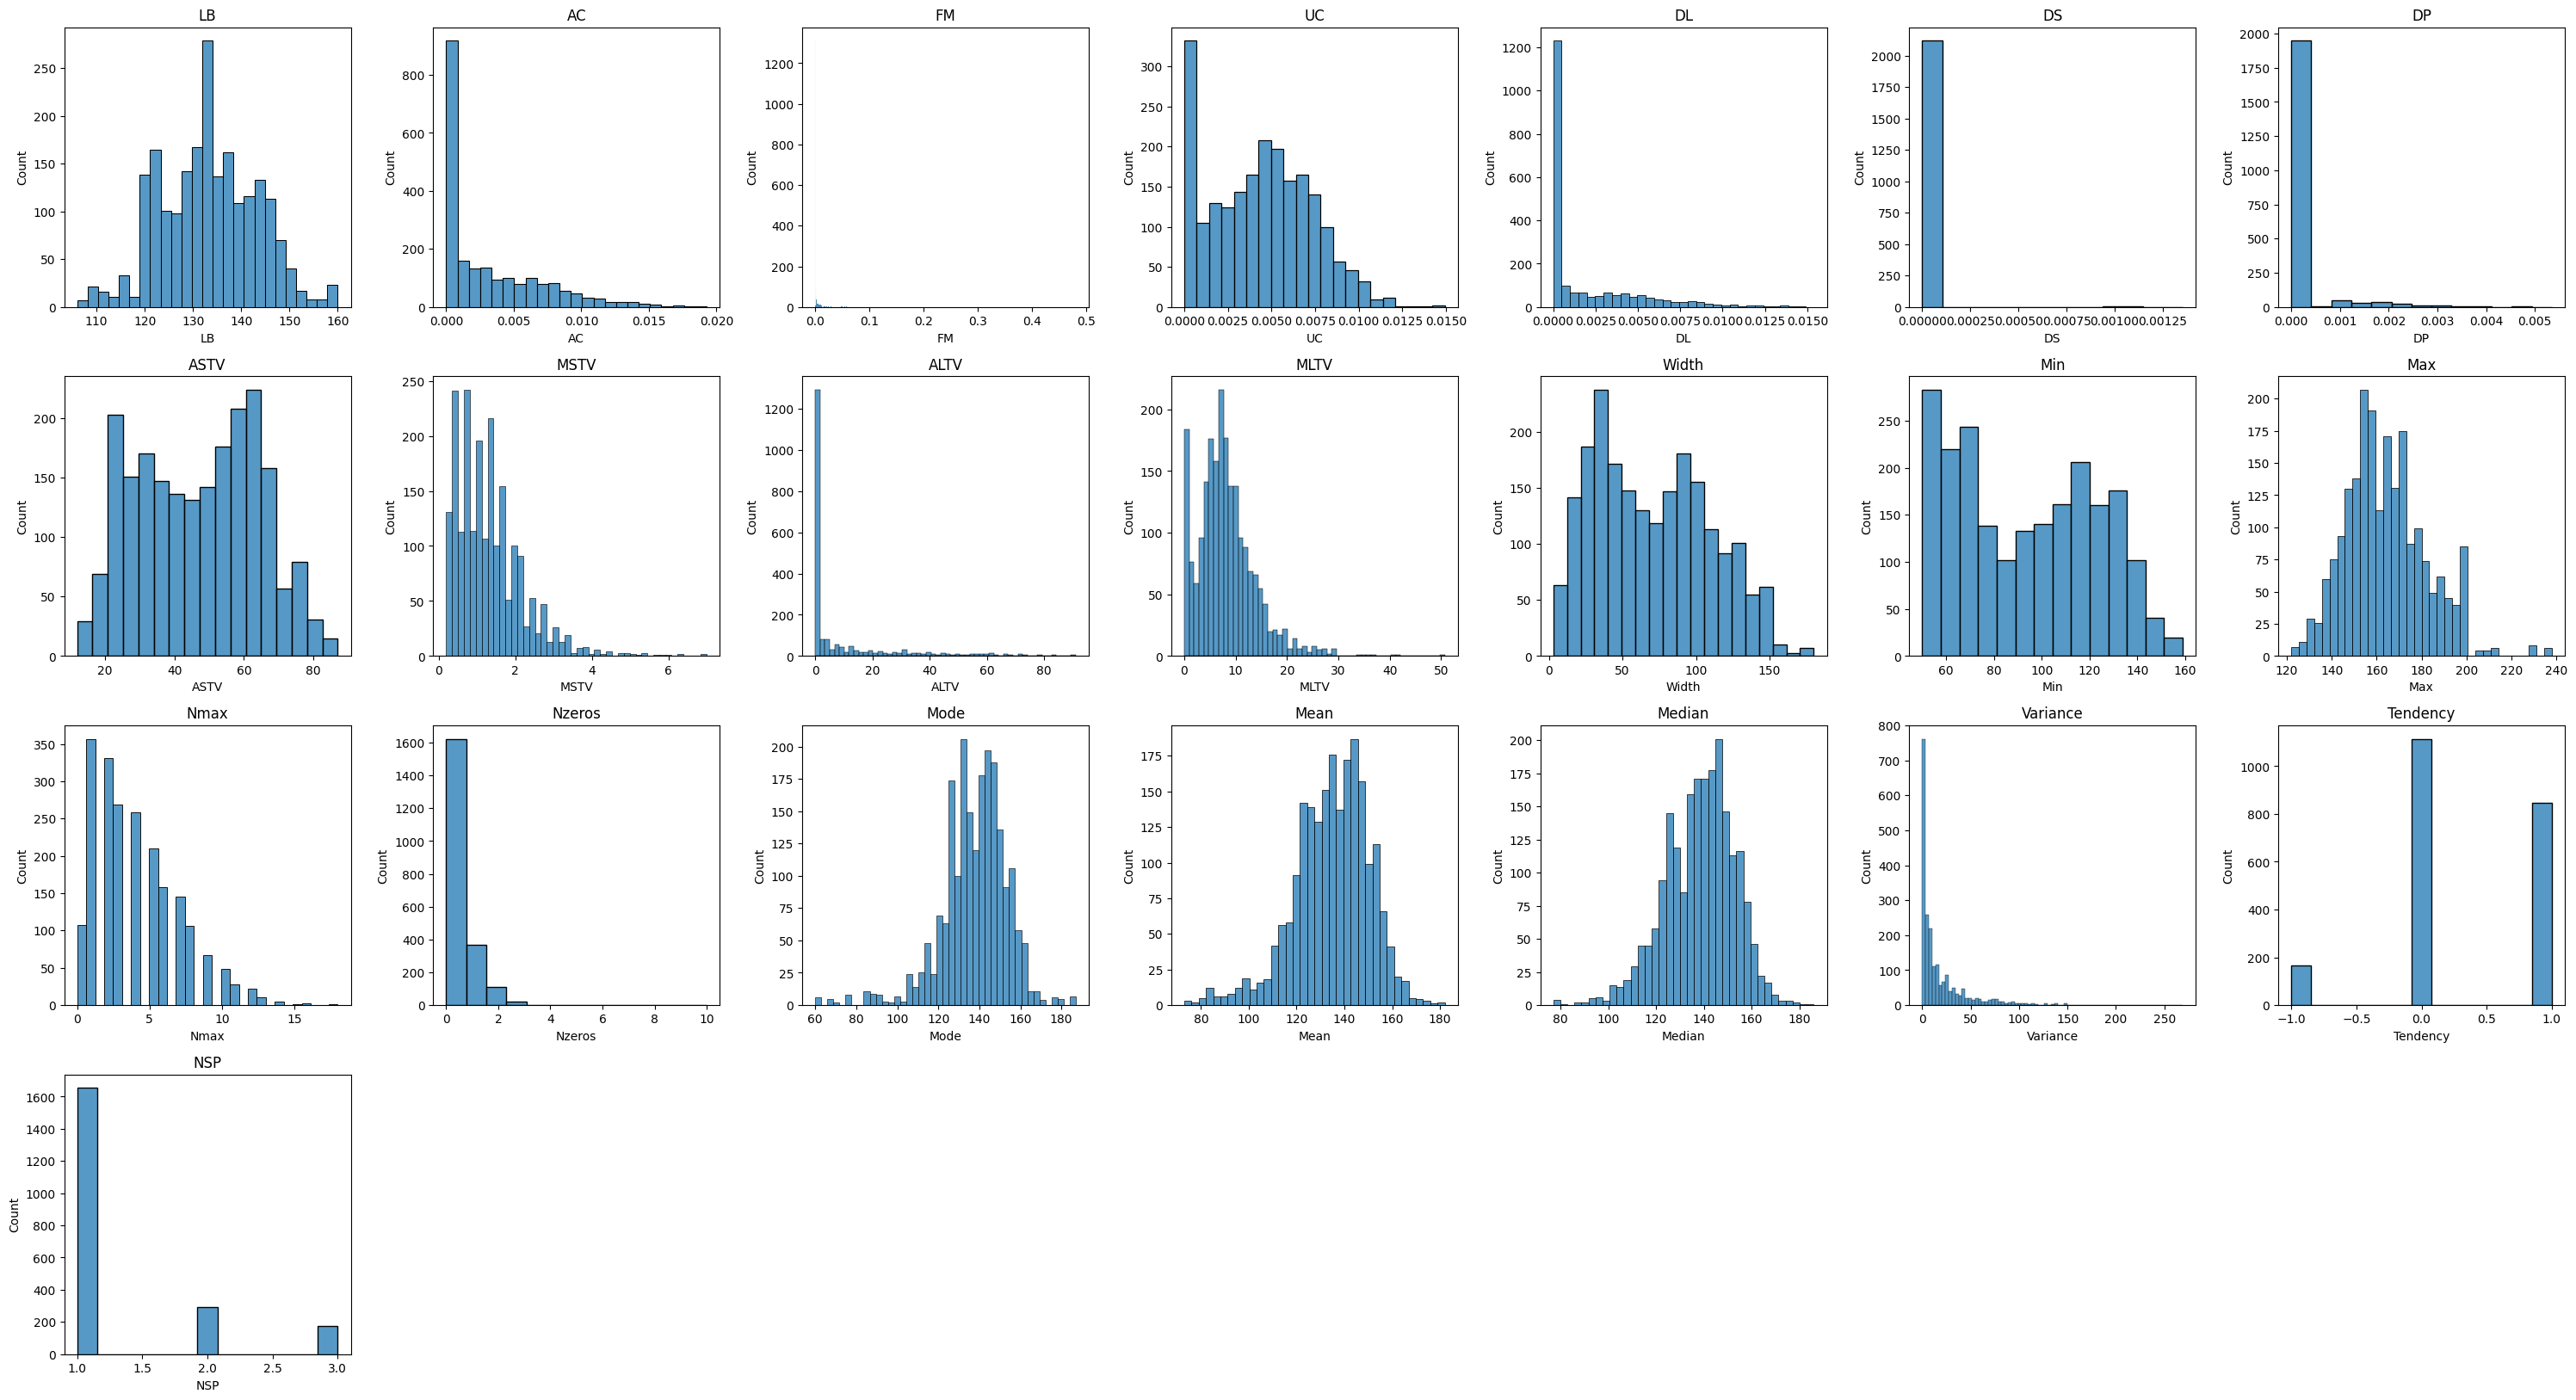

In [ ]:
# Create plot to display histograms for each feature in the df
plt.figure(figsize=(30, 20))

for i, col in enumerate(df2.columns):
    plt.subplot(5, 7, i + 1)
    sns.histplot(df2[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Let us now compare the various distributions for pairs of classes. Since the data for the NSP feature is unbalanced, we will here consider two random samples for the "Normal" and "Suspect" subclasses, reducing the size of their respective DataFrames to that of the "Pathological" subclass. This will  facilitate a visual comparison.

In [ ]:
# Create three subsets of df2 based based on the values of the NSP col
# For the last two subsets, only the first 176 rows will be considered
df2_path = df2[df2["NSP"]==3.0]
df2_susp = df2[df2["NSP"]==2.0].sample(n=176, random_state=42)
df2_norm = df2[df2["NSP"]==1.0].sample(n=176, random_state=42)

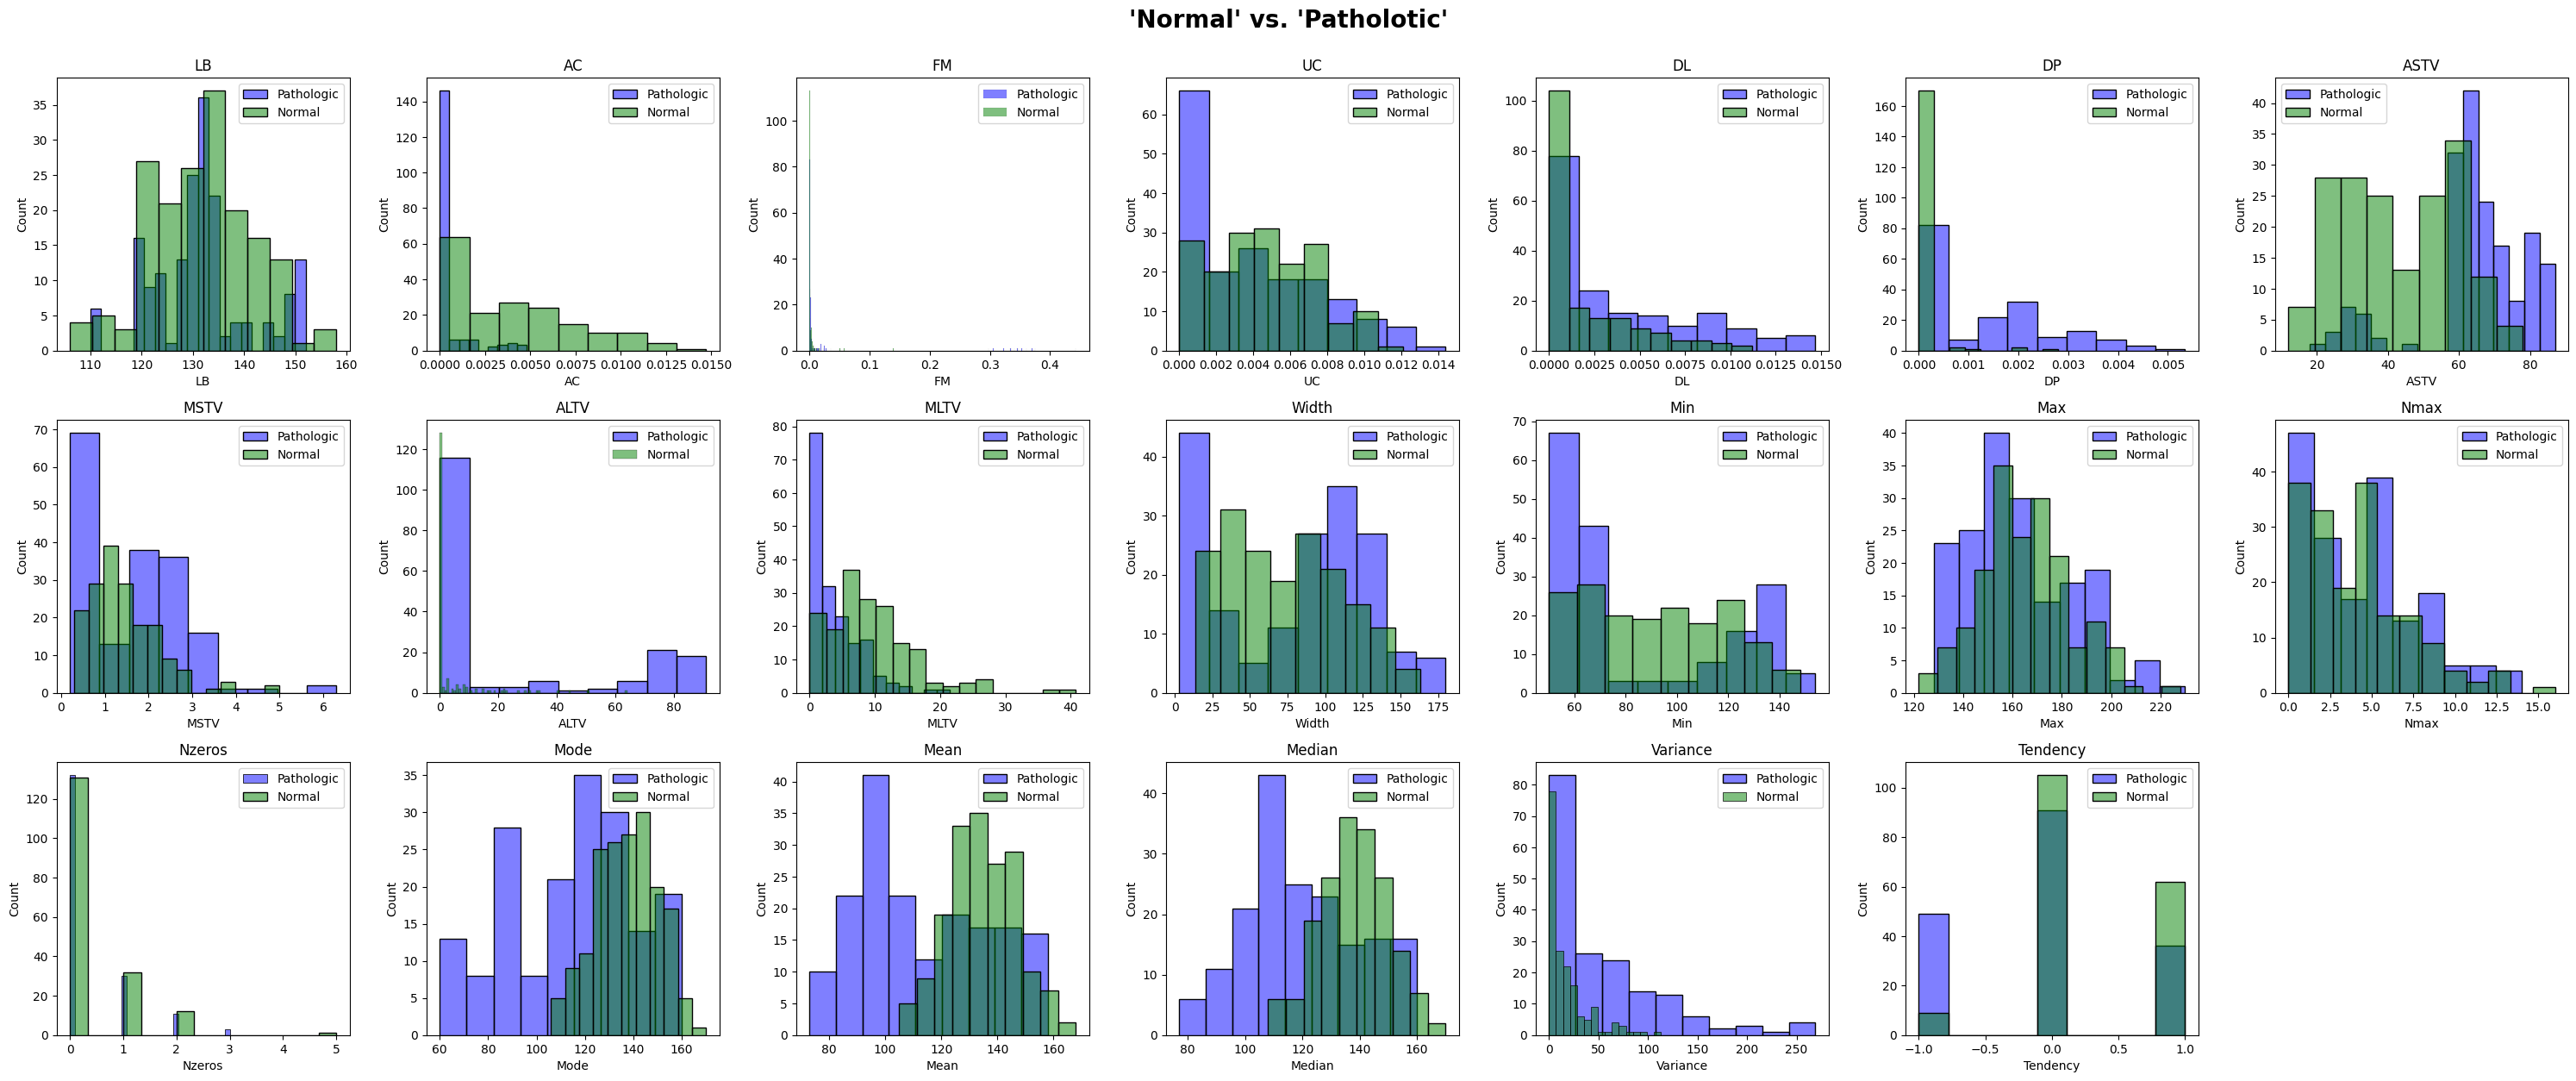

In [ ]:
# Class "Pathologic" vs. "Normal"
plt.figure(figsize=(30, 20))

num_cols = df2_path.shape[1] - 1
subplot_pos = 1  # Position of the subplot

for i, col in enumerate(df2_path.columns[:-1]):
    if col == 'DS': # also "FM"?
        continue

    plt.subplot(5, 7, subplot_pos)
    sns.histplot(df2_path[col], color='blue', label='Pathologic', alpha=0.5)
    sns.histplot(df2_norm[col], color='green', label='Normal', alpha=0.5)
    plt.title(col)
    plt.legend()

    subplot_pos += 1

plt.subplots_adjust(hspace=2.5, wspace=0.5)  # Adjust the spacing between subplots

plt.suptitle("'Normal' vs. 'Patholotic'", fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

The features such as "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" and "prolonged_decelerations" give rise to the most striking contrasts in the distributions of the two classes "Normal" and "Pathological", as do the features based on the measures of central tendency.

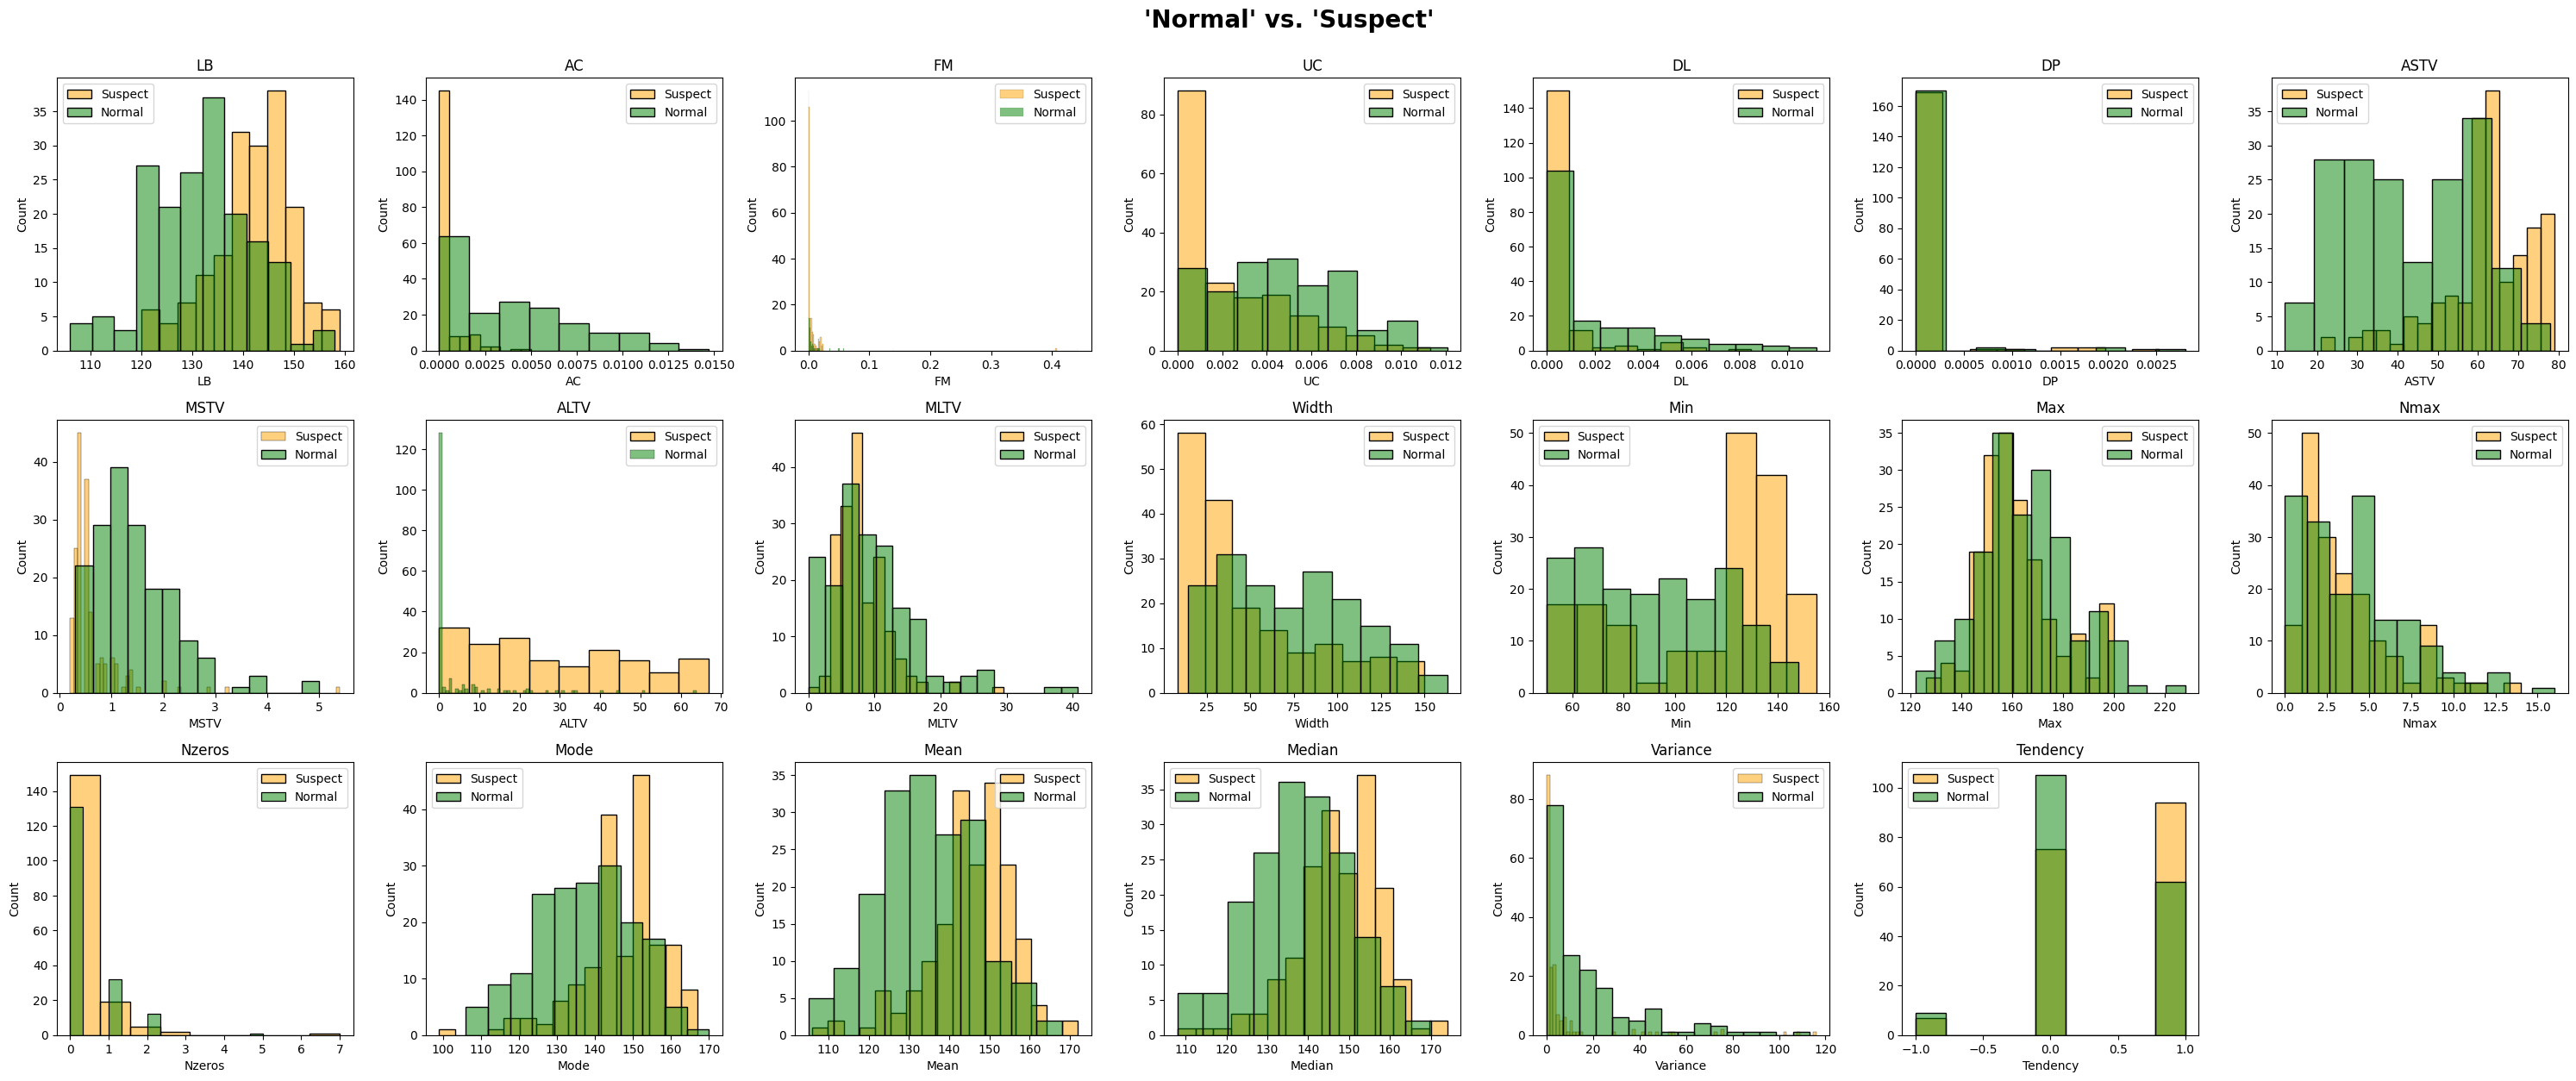

In [ ]:
# Class "Normal" vs. "Suspect"
plt.figure(figsize=(30, 20))

num_cols = df2_path.shape[1] - 1
subplot_pos = 1  # Position of the subplot

for i, col in enumerate(df2_path.columns[:-1]):
    if col == 'DS': # as above
        continue

    plt.subplot(5, 7, subplot_pos)
    sns.histplot(df2_susp[col], color='orange', label='Suspect', alpha=0.5)
    sns.histplot(df2_norm[col], color='green', label='Normal', alpha=0.5)
    plt.title(col)
    plt.legend()

    subplot_pos += 1

plt.subplots_adjust(hspace=0.5, wspace=0.5) # Adjust spacing between subplots
plt.suptitle("'Normal' vs. 'Suspect'", fontsize=20, fontweight='bold', y=1.0)

plt.tight_layout()
plt.show()


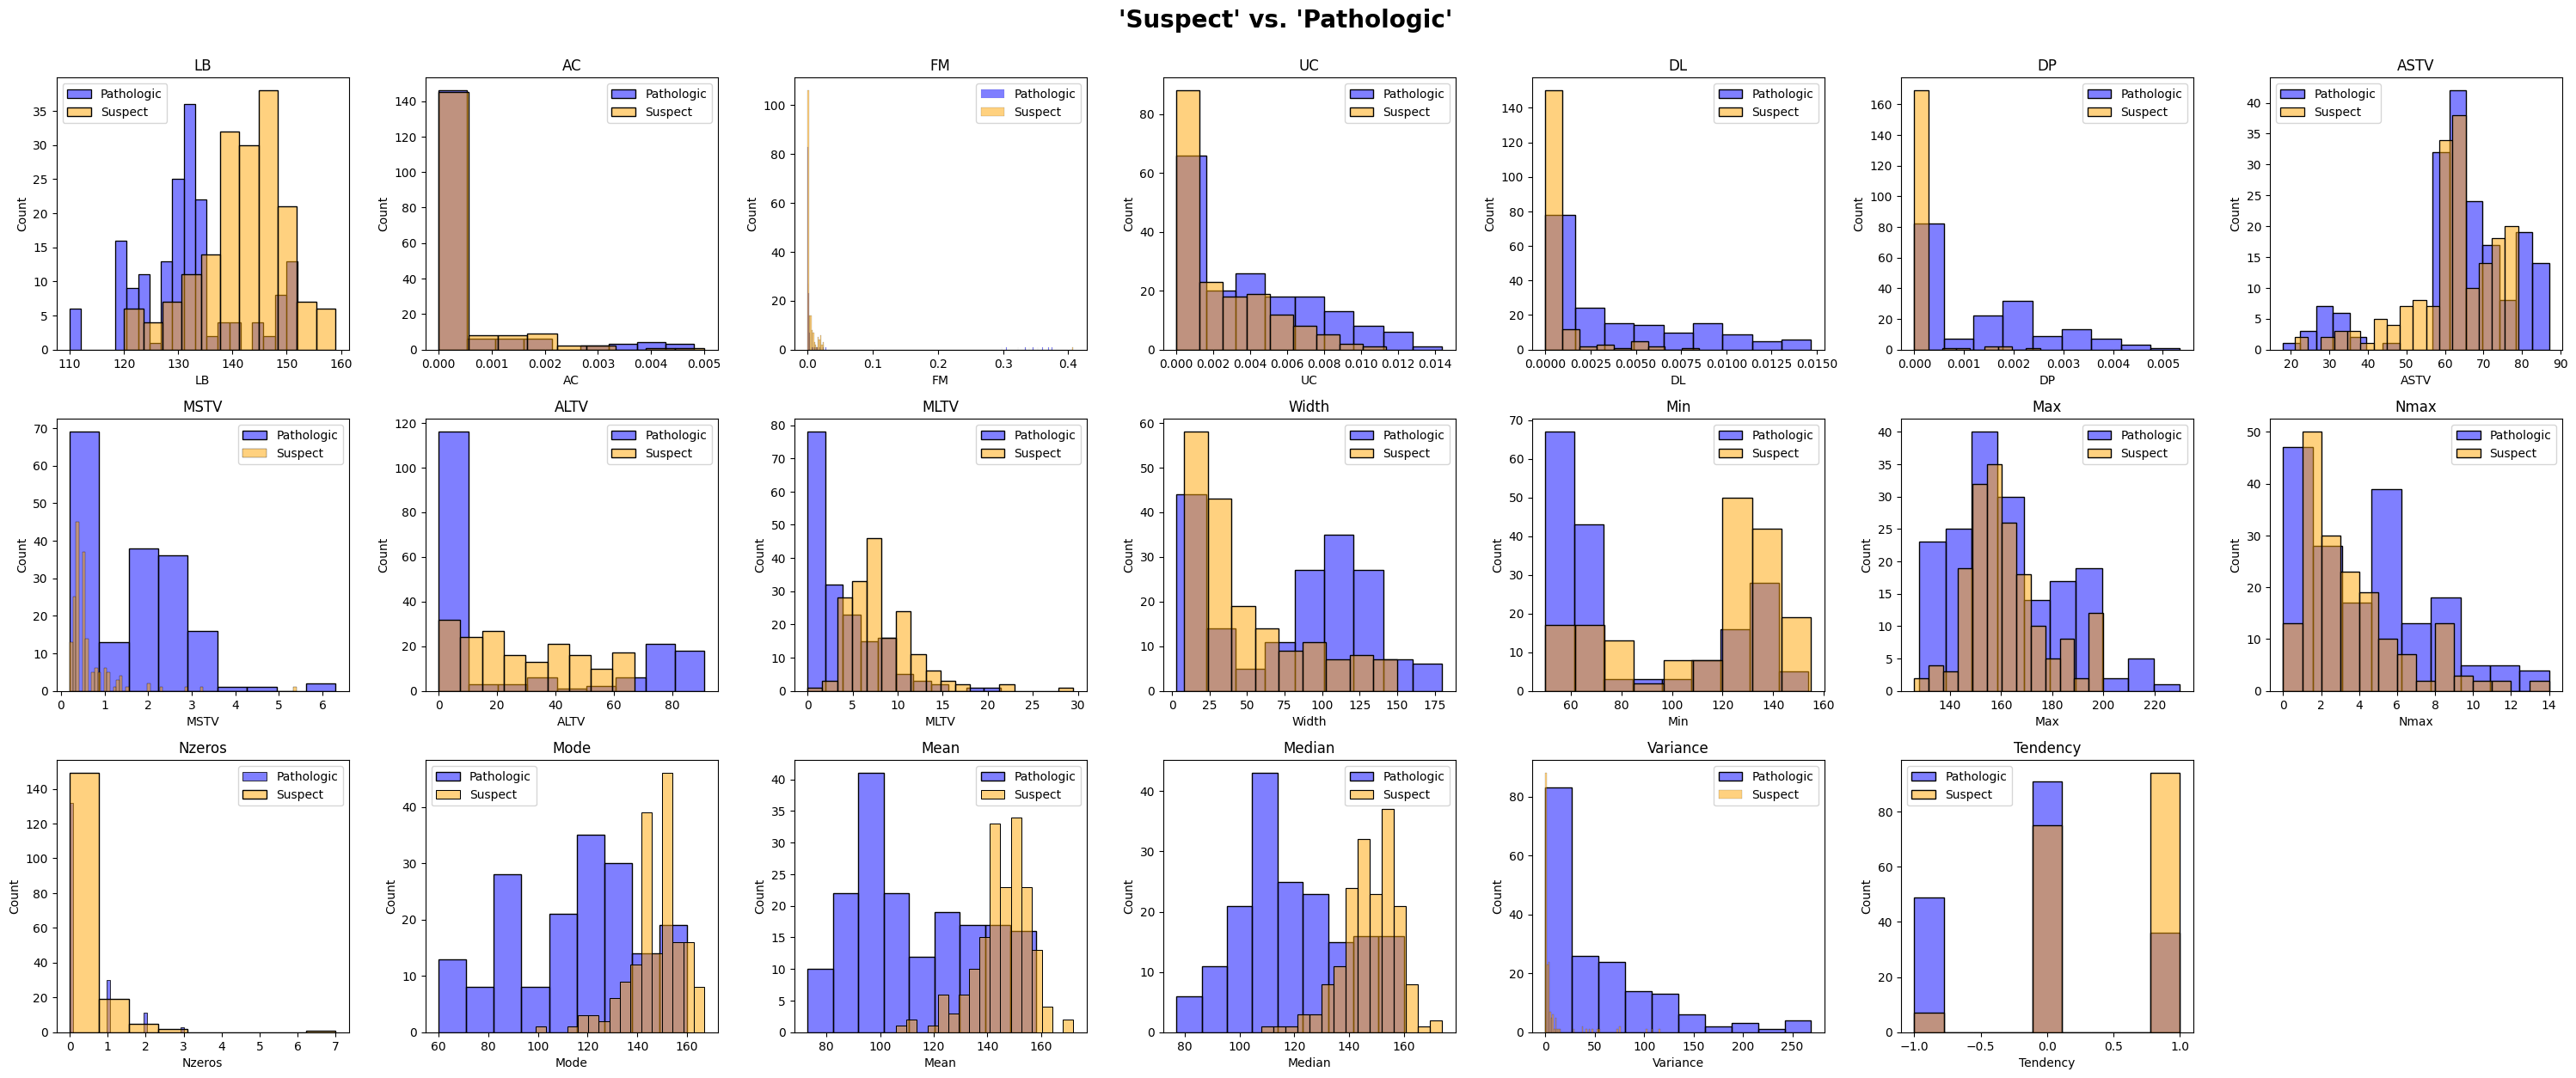

In [ ]:
# Class "Suspect" vs. "Pathologic"
plt.figure(figsize=(30, 20))

num_cols = df2_path.shape[1] - 1
subplot_pos = 1  # Position of the subplot

for i, col in enumerate(df2_path.columns[:-1]):
    if col == 'DS':  # as above
        continue

    plt.subplot(5, 7, subplot_pos)
    sns.histplot(df2_path[col], color='blue', label='Pathologic', alpha=0.5)
    sns.histplot(df2_susp[col], color='orange', label='Suspect', alpha=0.5)
    plt.title(col)
    plt.legend()

    subplot_pos += 1

plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots
plt.suptitle("'Suspect' vs. 'Pathologic'", fontsize=20, fontweight='bold', y=1.0)

plt.tight_layout()
plt.show()

<a name='2.2.3'></a>
### **2.2.3 Box plots**

In this last paragraph of this section, we will look at box-and-whisker plots for each feature of the DataFrame and then cross-referencing the data from the various NSP classes.

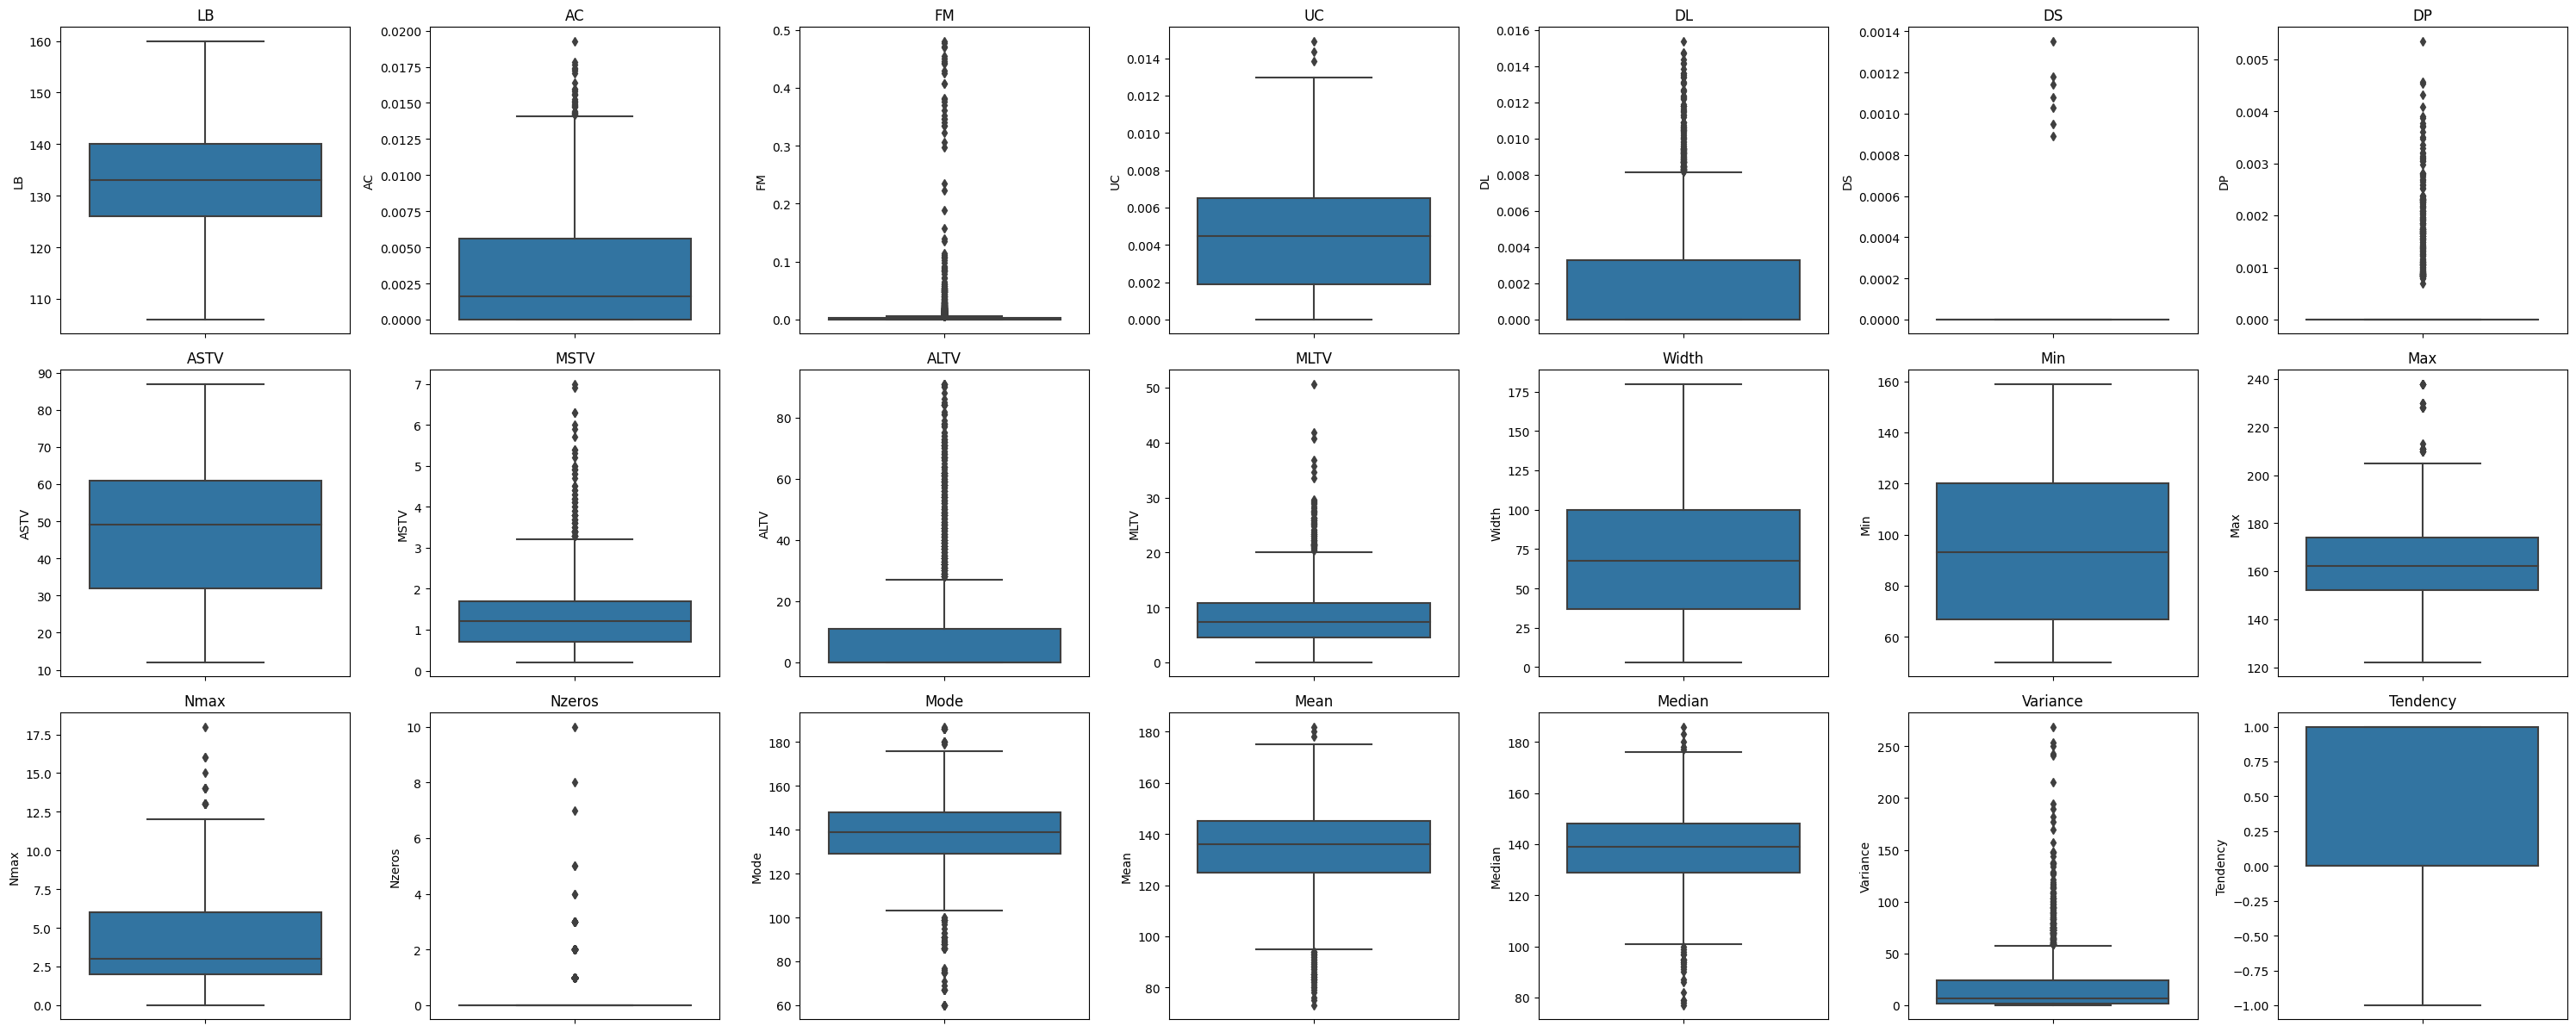

In [ ]:
# Display boxplots for each feature in the df
plt.figure(figsize=(30, 20))

for i, col in enumerate(df2.columns[:-1]):
    plt.subplot(5, 7, i + 1)
    sns.boxplot(data=df2, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
# Let's reconsider the full size for each class
df2_path = df2[df2["NSP"]==3.0]
df2_susp = df2[df2["NSP"]==2.0]
df2_norm = df2[df2["NSP"]==1.0]

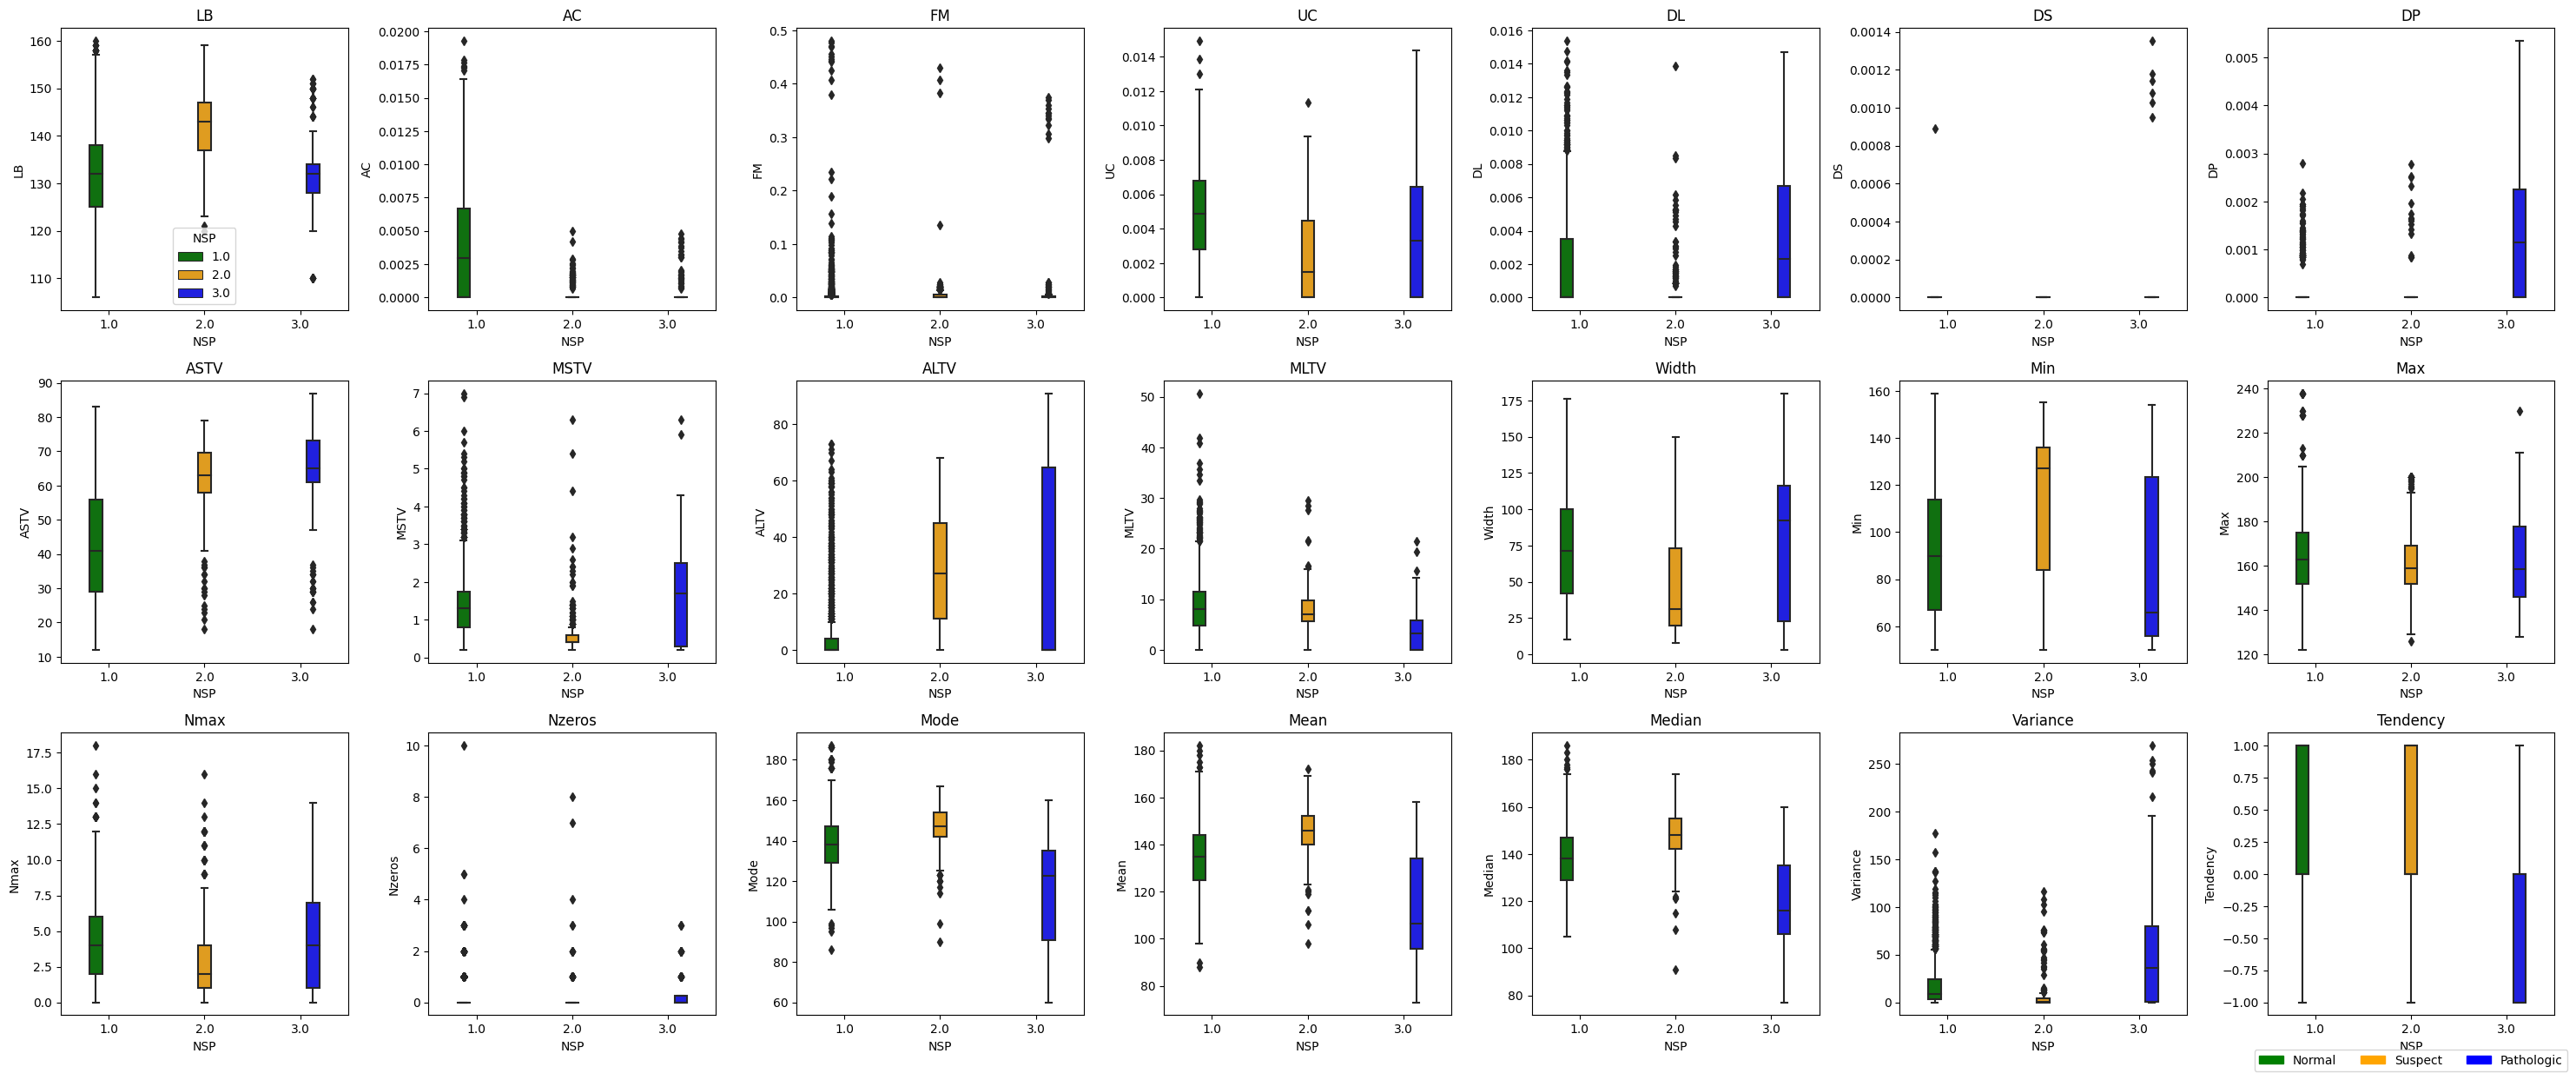

In [ ]:
import matplotlib.patches as mpatches

# Create plot to display boxplots for each feature in the df
plt.figure(figsize=(30, 20))

for i, col in enumerate(df2.columns[:-1]):
    ax = plt.subplot(5, 7, i + 1)
    sns.boxplot(data=df2,
                x='NSP',
                y=col, hue='NSP',
                palette={1.0: 'green',
                         2.0: 'orange',
                         3.0: 'blue'},
                width=0.4,
                fliersize=5)
    plt.title(col)
    if i != 0:
        ax.get_legend().remove()  # Remove legend from subsequent subplots

# Create the legend handles
green_patch = mpatches.Patch(color='green', label='Normal')
orange_patch = mpatches.Patch(color='orange', label='Suspect')
blue_patch = mpatches.Patch(color='blue', label='Pathologic')
handles = [green_patch, orange_patch, blue_patch]

# Place the legend outside the subplots
plt.legend(handles=handles,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.1),
           ncol=3)

plt.tight_layout()
plt.show()

<a name='2.3'></a>
## **2.3 Outliers**

As can be seen from the last box-and-whisker plot above, some features appear to include outliers. For example, the maximum value of "AC" in the first diagram (inherent in the aggregated data of the various classes) is well above the average (6x).

In [ ]:
df2["AC"].describe()

count    2126.000000
mean        0.003170
std         0.003860
min         0.000000
25%         0.000000
50%         0.001630
75%         0.005631
max         0.019284
Name: AC, dtype: float64

In [ ]:
# Looks like the max value is 6 times bigger than mean value
round(0.019284 / 0.003170)

6

Let's look at the descriptive statistics of each slice of the DataFrame corresponding to an "NSP" class for the feature "accelerations".

In [ ]:
print("Accelerations - Normal")
print(df2_norm["AC"].describe())
print("\n")
print("Accelerations - Suspect")
print(df2_susp["AC"].describe())
print("\n")
print("Accelerations - Pathological")
print(df2_path["AC"].describe())

Accelerations - Normal
count    1655.000000
mean        0.003983
std         0.003994
min         0.000000
25%         0.000000
50%         0.002967
75%         0.006653
max         0.019284
Name: AC, dtype: float64


Accelerations - Suspect
count    295.000000
mean       0.000261
std        0.000692
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.005004
Name: AC, dtype: float64


Accelerations - Pathological
count    176.000000
mean       0.000398
std        0.001030
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.004800
Name: AC, dtype: float64


We shall now locate the observations based on values greater than the boxplot upper whisker threshold, which is calculated below:

In [ ]:
# 75th quantile
upq = df2["AC"].quantile(0.75)
# 25th quantile
lq = df2["AC"].quantile(0.25)

In [ ]:
# Interquantile range
iqr = upq - lq
iqr

0.0056314263535

In [ ]:
# Upper threshold
upper = upq + (iqr * 1.5)
upper

0.01407856588375

In [ ]:
outliers = df2[df2["AC"] > upper]
outliers.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
84,145.0,0.014706,0.008403,0.002101,0.0,0.0,0.0,43.0,1.5,0.0,...,63.0,172.0,5.0,0.0,156.0,156.0,158.0,11.0,1.0,1.0
86,145.0,0.014230,0.025873,0.001294,0.0,0.0,0.0,40.0,1.1,0.0,...,73.0,186.0,4.0,0.0,165.0,163.0,165.0,11.0,1.0,1.0
182,138.0,0.017241,0.000000,0.005305,0.0,0.0,0.0,35.0,5.3,0.0,...,52.0,200.0,11.0,2.0,146.0,157.0,161.0,72.0,1.0,1.0
497,130.0,0.014178,0.091743,0.000834,0.0,0.0,0.0,32.0,2.4,0.0,...,50.0,170.0,10.0,0.0,159.0,150.0,155.0,27.0,1.0,1.0
498,130.0,0.015552,0.083981,0.001555,0.0,0.0,0.0,34.0,2.1,0.0,...,50.0,182.0,8.0,0.0,159.0,151.0,155.0,25.0,1.0,1.0


Since these outliers are localized in the "Normal" class and are much larger than the mean values of all classes, their presence could have a negative impact in the prediction of the other classes, so we tentatively
proceed  to exclude them.

In [ ]:
# Create a new df without outliers
df3 = df2[df2["AC"] < upper]

We would need more time to investigate whether it is possible to exclude other outliers. Here we limit ourselves to the sole elimination of the outliers discussed above.

<a name='2.4'></a>
## **2.4 Correlation**

The matrix above shows a moderate positive correlation between the features "ASTV" ("percentage of time with abnormal short term variability"), "ALTV" ("percentage of time with abnormal long term variability"), "DP" ("prolonged decelerations") and the target variable "NSP", which represents the health state of the fetus.

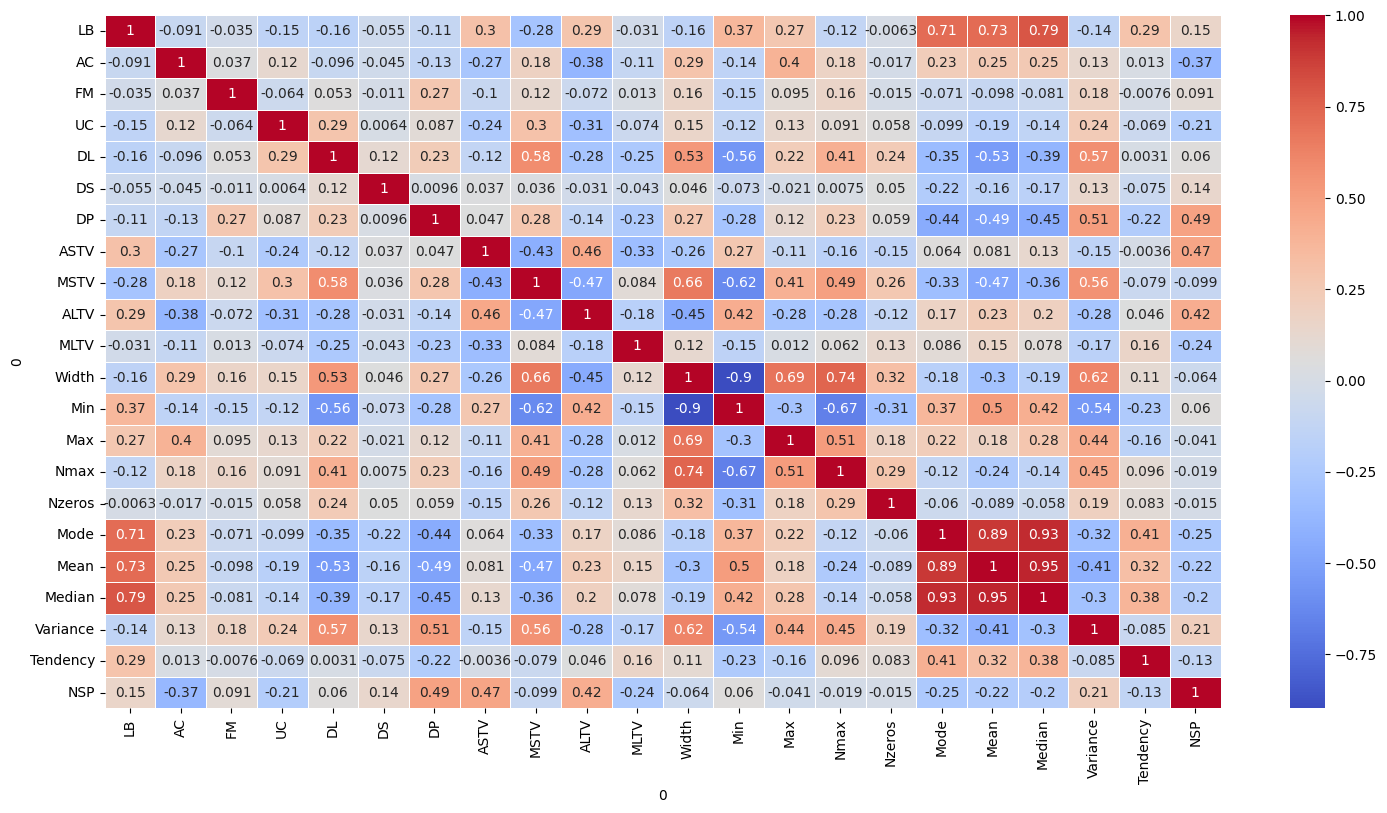

In [ ]:
# Create figure and make sure size is large enough
plt.figure(figsize=(18, 9))

# Adjust the spacing between cells
sns.heatmap(df3.corr(), annot=True, linewidths=0.5, cmap='coolwarm')

# Show the modified heatmap
plt.show()

[](https://)
<a name='3'></a>
# **3. Preprocessing**

As we approach the implementation of a Machine Learning model, the next step is to separate the target variable from the rest of the DataFrame.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [ ]:
y = df3['NSP']
X = df3.drop('NSP', axis=1)

In [ ]:
print(len(X))
print(len(y))

2096
2096


In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

[](https://)
<a name='4'></a>
# **4. Gradient Boosting Classifier**

In [ ]:
# Define the dictionary 'params_gbc'
params_gbc = {
    'gbc__n_estimators': [50, 100, 150, 300],
    'gbc__learning_rate': [0.01, 0.1, 1],
    'gbc__max_depth': [3, 7, 10, 15]
}

# Create a pipeline
steps = (StandardScaler(), GradientBoostingClassifier())
pipeline_gbc = make_pipeline(steps)

steps = [('scaler', StandardScaler()),
         ('gbc', GradientBoostingClassifier())]
pipeline_gbc = Pipeline(steps)


# Instantiate Grid Search for gbc
grid_gbc = GridSearchCV(pipeline_gbc,
                        param_grid=params_gbc,
                        scoring='accuracy',
                        cv=3,
                        verbose=1,
                        n_jobs=-1)

In [ ]:
# Fitting the popeline
grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbc', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gbc__learning_rate': [0.01, 0.1, 1],
                         'gbc__max_depth': [3, 7, 10, 15],
                         'gbc__n_estimators': [50, 100, 150, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
print(grid_gbc.best_score_)
print(grid_gbc.best_params_)

0.9459287531806616
{'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__n_estimators': 300}


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate= 0.1,
                                 max_depth=3)

In [ ]:
# Predict
start = time.time()
gbc_model = gbc.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gbc_model.predict(X_test)
end = time.time()
pred_time = (end - start)

In [ ]:
print('Fit time: {} / Predict time: {} ---- Accuracy: {}'.format(
    round(fit_time, 3),
    round(pred_time, 3),
    round((y_pred==y_test).sum()/len(y_pred), 2)))

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fit time: 5.361 / Predict time: 0.009 ---- Accuracy: 0.95
[[402   5   2]
 [ 13  56   1]
 [  3   1  41]]
              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       409
         2.0       0.90      0.80      0.85        70
         3.0       0.93      0.91      0.92        45

    accuracy                           0.95       524
   macro avg       0.93      0.90      0.91       524
weighted avg       0.95      0.95      0.95       524

